#### Notebook structure

Part 1: Define dependent and independent variables for first analysis pooled across time points

Part 2: rule out the influence of motion direction (coherent appearence of samples in one direction)

Part 3: Plot the Variables and Look at the relationship between them
Normalize the Variables to Zero Mean and Unit Variance
Check the covariance of continuous dep. variables with independent variables, check the covariance between variables

Part 4.1: Fit linear regressions including all independent variables as factors (for continuous dep. variables)
Check if the residuals are normally distributed and if the dv might depend on the subjects (random factor)
Include "subject" as random effect in a linear mixed effects model.

Part 4.2: Fit logistic regressions including all independent variables as factors (for binary responses, here: go/no-go)
Check the residuals, include subjects & compute a logistic mixed effects models.

Part 5.1: Model "pruning" - which factors do we actually need? - contiuous dv
Build 1 model for each iv combination (LMM)
Compare them with AIC
Part 5.2: Discrete DV - same a above, build seperate models and compare them (GLMM)

Part 6.1: Extend the data set (unstack) and include every single time point, with time as a seperate variable. Fit mixed effects models, remove variables with no significant effect from the analysis and compare the full and the reduced models with AIC.

Part 7.1: Post-Hoc analysis - explore the effects that we found in our models.

In [1]:
# Import packages and functions
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from my_funcs import get_p_in

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.graphics as smg
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
import statsmodels.genmod.bayes_mixed_glm as smgb

from yellowbrick.regressor import ResidualsPlot

warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.0.3'

import pymer4
from pymer4.models import Lmer

# load data file and define variable 'answer' (1 = correct answer, 0 = incorrect answer)

data = pd.read_csv('../2_cleaned/df_cleaned_rc_6.csv')
data['answer'] = 1-(np.abs(data.goResp - data.hitGoal))
data['indTrial'] = data.index

# get columns that contain p_in
p_in_names = ['pi_pos01','pi_pos02','pi_pos03','pi_pos04','pi_pos05','pi_pos06']
# columns with the target position
target_deg = ['posSet_1','posSet_2','posSet_3','posSet_4','posSet_5','posSet_6']
# columns with timing
time_names = ['tt_1','tt_2','tt_3','tt_4','tt_5','tt_6']
# columns with sample y position
ysamp_names = ['ty_1','ty_2','ty_3','ty_4','ty_5','ty_6'] 

# only the part of the data frame that holds probability information
dat = data.loc[:,p_in_names]

#### Part 1: Set some variables for the later analysis.
In the first part, we will pool our independent variable over the time points and look at the mean values.

We will look at the following dependent variables: 
    1. response time (continuous, time of hand movement onset relative to go signal)
    2. response (binary, "go" or "no go" response)
    3. answer correct/incorrect (binary)
    
The following dependent variables will go into the model
    1. mean probability of a hit (continuous between 0 and 1, defined as the cdf of a hit at the y position of the attacker)
    2. mean y position of the points relative to the y position of the attacker (continuous between -4 degree and 4 degree)

Based on a suggestion by Richard Schweitzer, we will also look at potential movement confounds. A series of probes appearing along the same axis might cause a motion percept, and result in a "go" response when the perceived motion is in the direction of the attacker end point. This will be dealt with in step 2

In [2]:
# set the variables we want to look at:
# the dependent variables
y_rt = data['rea_time'] # reaction time
y_resp = data['answer'] # response correct/incorrect
y_goresp = data['goResp'] # response go/nogo

# the independent variables
# for the first part, we will look at the average value of our independent variables over time
x_mean_pin = np.mean(dat, axis = 1) # probability of a hit
rel_ty = data.loc[:,target_deg].sub(data.loc[:,'attackerYPos'], axis = 0) # y position relative to attacker in degree
x_mean_ty = np.mean(rel_ty, axis = 1) # mean of y position
x_mean_dir = np.mean(np.diff(rel_ty), axis = 1) # mean of y position change

#### Step 2: estimation of motion effect
In order to see if the direction in which a stimulus moves has an influence, we do the following:
1. find trials where all target have been presented in the same direction (label uniform/chaotic)
2. find out if these trials started above or below the target -> assign direction to target/away
3. compute max distance covered
4. check if there is a difference between uniform and chaotic trials when the same goal width was covered
5. check if there is a difference between uniform and chaotic trials when the same mean direction was shown

This data set includes 699 trials with uniform motion


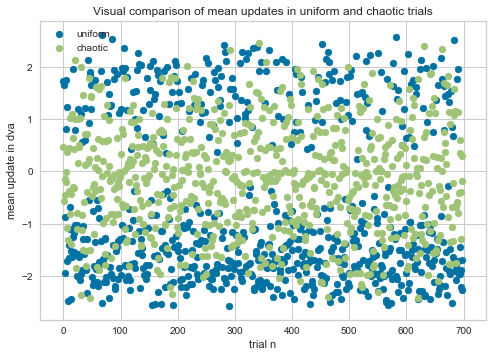

In [3]:
# get the differences between samples
x_dir = np.diff(rel_ty)

# cut off after the 3rd sample, because on average the hand movement started after the 3rd sample was shown
x_dir_cut = x_dir[:,:3]

# find all rows where the signs are identic (update in the same direction)
signs = np.sign(x_dir_cut).T
bool_signs = signs == signs[0,:].T
list_sign = np.all(bool_signs == bool_signs[0,:], axis = 0)
print('This data set includes {} trials with uniform motion'.format(np.sum(list_sign)))

# write to data
data['unidir'] = list_sign
data['start_sign'] = np.sign(rel_ty.posSet_1)

# compute how much of the goal was covered between the updates
# this might is important because more goal covered -> more information about the true position
# when comparing uniform and chaotic motion, we want to match for how much of the goal was covered
data['cover'] = np.max(rel_ty, axis = 1) - np.min(rel_ty, axis = 1)

# next, express the direction of the update relative to attacker (negative values approaching attacker, 
# positive values going away from attacker)
# we do this by multiplying the direction in which the samples moved with the sign of the first position 
# (information if that position was below or above the attacker)
# I am note sure if this is a valid approach for trials in which the samples cross the y position of the attacker.
x_dir_norm = x_dir_cut
x_dir_norm = x_dir_cut * np.sign(rel_ty.posSet_1)[:, None]

# compute the mean difference over the normalized values
x_dir_mean_norm =  np.mean(x_dir_norm, axis = 1)

# visually compare the means of unidirectional and non_unidirectional trials
uni_mean = x_dir_mean_norm[np.where(data.unidir)[0]]
chaos_mean = x_dir_mean_norm[np.where(data.unidir == False)[0]]
plt.title('Visual comparison of mean updates in uniform and chaotic trials')
plt.scatter(np.arange(len(uni_mean)),uni_mean, label = 'uniform')
plt.scatter(np.arange(len(uni_mean)),chaos_mean[:len(uni_mean)], label = 'chaotic')
plt.xlabel('trial n')
plt.ylabel('mean update in dva')
plt.legend()

# round the cover value to full numbers to facilitate matching the conditions
data.loc[:,'cover'] = np.round(data['cover'])
# intialize table to save values
rt_cover = np.zeros((len(np.unique(data.cover)), 2))
resp_cover = np.zeros((len(np.unique(data.cover)), 2))

# look for trials with the same "cover" value
for id_c, cover in enumerate(np.unique(data.cover)):
    cov_dat = data[data.cover == cover]
    # seperate them in uniform and chaotic trials
    uni_dat = cov_dat[cov_dat.unidir]
    chaos_dat = cov_dat[cov_dat.unidir == False]
    # save the mean of each condition
    rt_cover[id_c,0] = np.mean(uni_dat.rea_time)
    rt_cover[id_c,1] = np.mean(chaos_dat.rea_time)
    resp_cover[id_c,0] = np.mean(uni_dat.goResp)
    resp_cover[id_c,1] = np.mean(chaos_dat.goResp)

# we try the same with the direction in which the samples moved
# initialize data frame
rt_dir = np.zeros((10,2))
resp_dir = np.zeros((10,2))

for id_dir, m_dir in enumerate(np.linspace(-3, 3, 10)):
    # get the step size between samples
    step = np.unique(np.round(np.diff(np.linspace(-3, 3, 10)), 5))
    # get all trials in that "mean movement" range
    dir_idx = np.where((x_dir_mean_norm >= m_dir) & (x_dir_mean_norm < m_dir+step))[0]
    dir_dat = data.loc[dir_idx,:]
    # divide in chaotic and uniform trials
    uni_dir = dir_dat[dir_dat.unidir]
    chaos_dir = dir_dat[dir_dat.unidir == False]
    # save the mean in a table
    rt_dir[id_dir,0] = np.mean(uni_dir.rea_time)
    rt_dir[id_dir,1] = np.mean(chaos_dir.rea_time)
    resp_dir[id_dir,0] = np.mean(uni_dir.goResp)
    resp_dir[id_dir,1] = np.mean(chaos_dir.goResp)

First remark: On average, uniform trials have more absolute motion than chaotic trials. That makes sense, because in chaotic trials, positive and negative signs can cancel each other out.

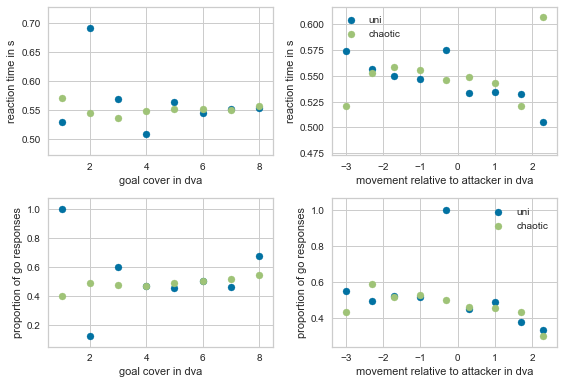

In [4]:
# plot the reaction times and the proportion of "go" responses as a function of the goal part covered 
# and as a function of the movement.

# if uniform motion provides a stronger signal than chaotic motion, we should see faster reaction times 
# in the uniform trials. Also, more "go" responses are expected when the uniform motion is in the direction
# of the attacker (negative motion values) than for chaotic motion.

fig_mov, axs_mov = plt.subplots(2,2)
# plot goal cover in both cases
axs_mov[0,0].scatter(np.arange(9)[1:], rt_cover[:,0])
axs_mov[0,0].scatter(np.arange(9)[1:], rt_cover[:,1])
axs_mov[0,0].set_xlabel('goal cover in dva')
axs_mov[0,0].set_ylabel('reaction time in s')
# plot direction in both cases
axs_mov[0,1].scatter(np.round(np.linspace(-3, 3, 10),1), rt_dir[:,0], label = 'uni')
axs_mov[0,1].scatter(np.round(np.linspace(-3, 3, 10),1), rt_dir[:,1], label = 'chaotic')
axs_mov[0,1].set_xlabel('movement relative to attacker in dva')
axs_mov[0,1].set_ylabel('reaction time in s')

axs_mov[0,1].legend()

axs_mov[1,0].scatter(np.arange(9)[1:], resp_cover[:,0])
axs_mov[1,0].scatter(np.arange(9)[1:], resp_cover[:,1])
axs_mov[1,0].set_xlabel('goal cover in dva')
axs_mov[1,0].set_ylabel('proportion of go responses')
axs_mov[1,1].scatter(np.round(np.linspace(-3, 3, 10),1), resp_dir[:,0], label = 'uni')
axs_mov[1,1].scatter(np.round(np.linspace(-3, 3, 10),1), resp_dir[:,1], label = 'chaotic')
axs_mov[1,1].set_xlabel('movement relative to attacker in dva')
axs_mov[1,1].set_ylabel('proportion of go responses')

axs_mov[1,1].legend()

plt.tight_layout()



From visual inspection, we don't see a difference between the chaotic and and uniform motion. In the goal cover plots and in the proportion of goal responses plots. However, it could be that reaction times are slightly when matching trials for movement size. We will try to establish that statistically.

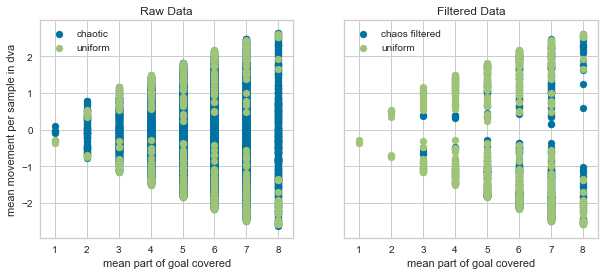

In [5]:
# first, we want to see if motion size and goal cover depend on each other:

figDir, axsDir = plt.subplots(1,2, figsize = (10,4), sharex = True, sharey = True)
axsDir[0].set_title('Raw Data')
axsDir[0].scatter(data.cover[data.unidir == False],x_dir_mean_norm[data.unidir == False], label = 'chaotic')
axsDir[0].scatter(data.cover[data.unidir],x_dir_mean_norm[data.unidir], label = 'uniform')
axsDir[0].set_xlabel('mean part of goal covered')
axsDir[0].set_ylabel('mean movement per sample in dva')
axsDir[0].legend()

# When the motion was uniform, a big goal coverage also predicts large mean motion. 
# Also, as there are more chaotic than uniform trials, we will try to filter the chaotic trials such 
# that the distribution of mean motion is the same.
np.random.seed(2001)
filtered_chaos = []

for id_dir, m_dir in enumerate(np.linspace(-3, 3, 10)):
    # get the step size between samples
    step = np.unique(np.round(np.diff(np.linspace(-3, 3, 10)), 5))
    
    # get all trials in that "mean movement" range
    dir_idx = np.where((x_dir_mean_norm >= m_dir) & (x_dir_mean_norm < m_dir+step))[0]
    dir_dat = data.loc[dir_idx,:]
    # divide in chaotic and uniform trials
    uni_dir = dir_dat[dir_dat.unidir]
    chaos_dir = dir_dat[dir_dat.unidir == False]
    
    # how many data points do we have here from the uniform type?
    n_dp = len(uni_dir)
    chaos_sample = np.random.choice(chaos_dir.index, n_dp)
    filtered_chaos = np.hstack([filtered_chaos,chaos_sample])
    
filtered_chaos.sort()

axsDir[1].set_title('Filtered Data')
axsDir[1].scatter(data.cover[filtered_chaos],pd.DataFrame(x_dir_mean_norm).loc[filtered_chaos,:], label = 'chaos filtered')
axsDir[1].scatter(data.cover[data.unidir],x_dir_mean_norm[data.unidir], label = 'uniform')
axsDir[1].set_xlabel('mean part of goal covered')
#axsDir[1].set_ylabel('mean movement per sample in dva')
axsDir[1].legend();

    

Ttest_relResult(statistic=-0.1916747555869642, pvalue=0.8482094912538852)

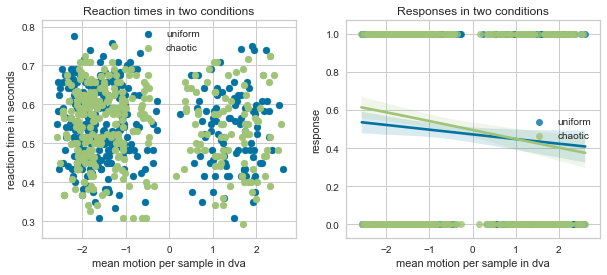

In [6]:
# Make a basic scatter plot of the trials now to see if the reaction time differs between the chaotic and the uniform condition
figMot, axsMot = plt.subplots(1,2, figsize = (10,4))
axsMot[0].set_title('Reaction times in two conditions')
axsMot[0].scatter(x_dir_mean_norm[data.unidir], data.rea_time[data.unidir], label = 'uniform')
axsMot[0].scatter(pd.DataFrame(x_dir_mean_norm).loc[filtered_chaos,:], data.rea_time[filtered_chaos], label = 'chaotic')
axsMot[0].legend()
axsMot[0].set_xlabel('mean motion per sample in dva')
axsMot[0].set_ylabel('reaction time in seconds')

# Make a regression plot to see if the response depends on the motion
axsMot[1].set_title('Responses in two conditions')
sns.regplot(x_dir_mean_norm[data.unidir], data.goResp[data.unidir], logistic = True, ax = axsMot[1], label = 'uniform')
sns.regplot(pd.DataFrame(x_dir_mean_norm).loc[filtered_chaos,:], data.goResp[filtered_chaos], logistic = True, ax = axsMot[1], label = 'chaotic')
axsMot[1].legend()
axsMot[1].set_xlabel('mean motion per sample in dva')
axsMot[1].set_ylabel('response')

# compare reaction times in uniform and chaotic cases with a t-test
stats.ttest_rel(data.rea_time[data.unidir],data.rea_time[filtered_chaos], nan_policy = 'omit')

The t-test suggests that the reaction times are not significantly different in uniform vs. chaotic trials.
The cofidence intervals also overlap in the logisitic regression, and it looks like there is no difference there.

Hence, we will drop the motion direction from here.

#### Part 3: Visual inspection
Look at the distribution of the data - normalize when neccessary

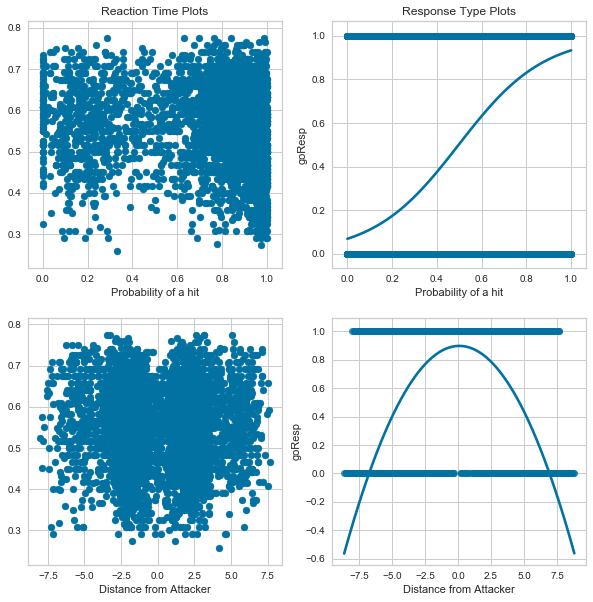

In [7]:
# Move on - next, we'll look at the other two parameters that could influence the responses
# make scatter plots between these
fig_sc, axs_sc = plt.subplots(2,2, figsize = (10,10))
plt.tight_layout

axs_sc[0,0].set_title('Reaction Time Plots')
axs_sc[0,0].scatter(x_mean_pin, y_rt)
axs_sc[0,0].set_xlabel('Probability of a hit')
axs_sc[0,1].set_title('Response Type Plots')
sns.regplot(x_mean_pin, y_goresp, logistic = True, ci = None, ax = axs_sc[0,1])
axs_sc[0,1].set_xlabel('Probability of a hit')
axs_sc[1,0].scatter(x_mean_ty, y_rt)
axs_sc[1,0].set_xlabel('Distance from Attacker')
sns.regplot(x_mean_ty, y_goresp, logistic = False, ci = None, ax = axs_sc[1,1], order = 2)
#axs_sc[1,1].scatter(x_mean_ty, y_resp)
axs_sc[1,1].set_xlabel('Distance from Attacker');
#axs_sc[2,0].scatter(x_mean_dir, y_rt)
#axs_sc[2,0].set_xlabel('Mean difference of Attacker distance')
#axs_sc[2,1].scatter(x_mean_dir, y_resp)
#axs_sc[2,1].set_xlabel('Mean difference of Attacker distance');

From the reaction time plots, we can see that they are not normally distributed. The probability of a "hit" (first plot) seems to have the least variance around "0.5" and higher variability towards 0 and 1. 

In the second reaction time plot plot (distance between sample and attacker), we see a symetric distribution that seems to be centered around "0" with lower variance at "0". The sign in front of the distance indicates if the mean was above or below the attacker. We don't assume a difference between these conditions (and have a separate factor to check for it), so we can normalize the data to absolut values here.



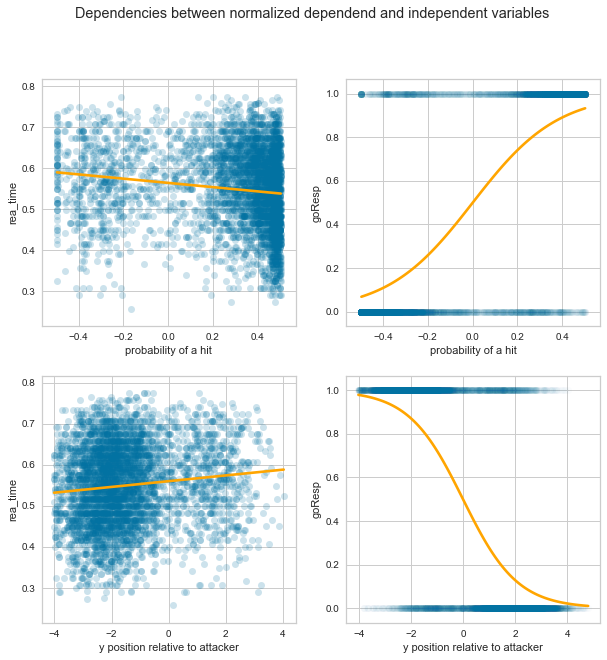

In [8]:
# normalize all independent variables:

# the independent variables
x_n_pin = x_mean_pin # probability of a hit
x_n_ty = abs(x_mean_ty) # mean of y position

# scale all variables to zero mean and unit variance
# we will only apply centering of the variables
x_n_pin = x_n_pin - np.mean(x_n_pin)
x_n_ty = x_n_ty - np.mean(x_n_ty)


# and plot again
fig_norm, axs_norm = plt.subplots(2,2, figsize = (10,10))
fig_norm.suptitle('Dependencies between normalized dependend and independent variables')
plt.tight_layout

sns.regplot(x_n_pin, y_rt, order = 1, ci = None, ax = axs_norm[0,0], line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2})
sns.regplot(x_n_pin, y_goresp, logistic = True, ci = None, ax = axs_norm[0,1], line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.02})
axs_norm[0,0].set_xlabel('probability of a hit')
axs_norm[0,1].set_xlabel('probability of a hit')

sns.regplot(x_n_ty, y_rt, order = 1, ci = None, ax = axs_norm[1,0], line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.2})
sns.regplot(x_n_ty, y_goresp, logistic = True, ci = None, ax = axs_norm[1,1], line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.02})

axs_norm[1,0].set_xlabel('y position relative to attacker')
axs_norm[1,1].set_xlabel('y position relative to attacker');

It seems like there is a negative correlation between reaction time and p(hit) -> the more likely a hit, the faster the response. We also see a positive correlation between reaction time and mean distance to goal -> the bigger the distance, the slower the reaction time.

We see that there are less reaction time data points for low hit probabilities and large distances to the attacker. This can be related to the fact that reaction times are only available for "go" responses - the less likely the trial is a hit, the less likely the answer is correct. And also - the further away the sample is from the attacker, the less likely we have a hit. 

For the proportion of go responses we can say that they nicely follow the probability/distance between samples and attacker: More go responses are made for high hit probabilities, and for a smaller distance between sample and attacker.

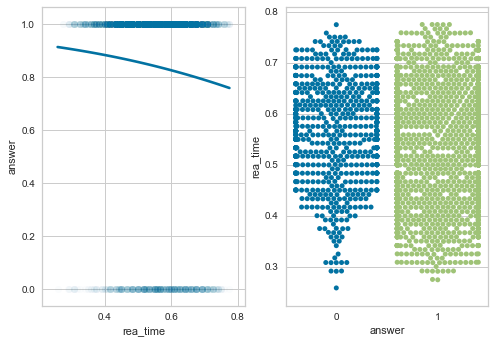

In [9]:
# Question: Does the reaction time differ between for correct/ incorrect answers?

fig, ax_rt_resp = plt.subplots(1,2)
sns.regplot(y_rt, y_resp, logistic = True, ci = None, ax = ax_rt_resp[0], scatter_kws = {'alpha': 0.02})
sns.swarmplot(x = 'answer', y = 'rea_time', data = data, ax = ax_rt_resp[1]);


It seems that the fastest answers are mostly correct.

#### Compute some basic pearson correlataions

just to help understanding - this formula is used to compute covariance
but below, we will use np.cov which gives us the covariance matrix

cov = (np.sum(X - np.mean(X)) * (Y - np.mean(Y)) ) * 1/(len(Y)-1)

In [10]:
# first, filter all nans
nan_idx = np.where(np.isnan(y_rt))
x_f_pin = np.delete(x_n_pin.values,nan_idx[0]) #x_n_pin.drop(nan_idx[0])
x_f_ty = np.delete(x_n_ty.values,nan_idx[0])
#x_f_dir = np.delete(x_n_dir,nan_idx[0])
x_f_sub = np.delete(data.subject.values, nan_idx[0])

# we start computing the correlation for reaction times because those are easier (continuous)
y_f_rt = y_rt.drop(nan_idx[0])

In [11]:
cov_pin = np.cov(x_f_pin, y_f_rt)
cov_ty = np.cov(x_f_ty, y_f_rt)
#cov_dir = np.cov(x_f_dir, y_f_rt)

In [12]:
print(cov_pin)
print(cov_ty)
#print(cov_dir)

[[ 0.07276306 -0.00376372]
 [-0.00376372  0.00930581]]
[[2.39484383 0.01677976]
 [0.01677976 0.00930581]]


The Pearson Correlation Coefficient helps us to interpret the data we see it is calculated as:

pearson_r = cov(X,Y)/(np.stdv(X)*np.stdv(Y))

In [13]:
# as before, we don't use this formula but take the pearsons r function from scipy
pr_pin, pv_pin = stats.pearsonr(x_f_pin, y_f_rt)
pr_ty, pv_ty = stats.pearsonr(x_f_ty, y_f_rt)
#pr_dir, pv_dir = stats.pearsonr(x_f_dir, y_f_rt)


In [14]:
print(pr_pin, pv_pin)
print(pr_ty, pv_ty)
#print(pr_dir, pv_dir)

-0.14463879388233009 5.4729719514874675e-22
0.11240098772862765 7.727779550498245e-14


In [15]:
pr_pin_ty, pv_pin_ty = stats.pearsonr(x_f_pin, x_f_ty)
#pr_pin_dir, pv_pin_dir = stats.pearsonr(x_f_pin, x_f_dir)
#pr_dir_ty, pv_dir_ty = stats.pearsonr(x_f_dir, x_f_ty)

print(pr_pin_ty, pv_pin_ty)
#print(pr_pin_dir, pv_pin_dir)
#print(pr_dir_ty, pv_dir_ty)

-0.8847115017449093 0.0


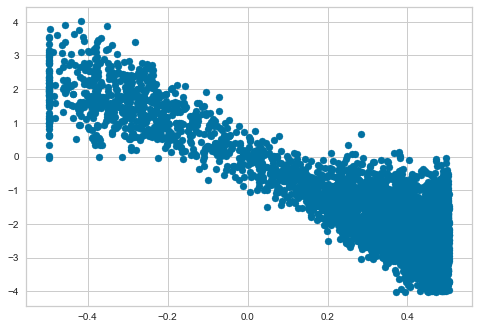

In [16]:
# plot how probability and the distance form the target correlate with each other
plt.scatter(x_f_pin, x_f_ty);

#### Interpretation

One important thing to note here is that I build pearson correlations only with respect to the reaction time. That means, all responses considered here are go responses

We have seen that there is a correlation between the p_in value and reaction times (the higher the normalized probability, e.g. the smaller uncertainty), the shorter (faster) reaction times. Pearson's r is -0.14
There also is a positive correlation between the mean target position and the reaction time. The further the target is away from the attacker position, the slower the reaction time. Pearson's R is 0.11

Those two measures are also highly correlated - the bigger p_in, the smaller ty. Pearson's r is -.88. This can be interpreted as in "the closer the average sample was to the attacker, the more likely this trial was to be a hit trial."

#### Part 4.1 fit linear regressions (Reaction Times) - No correction for subjects, Time averaged

Coefficients: 
 [-0.06090608 -0.00185833]
MSE: 0.01
Coefficient of determination: 0.02


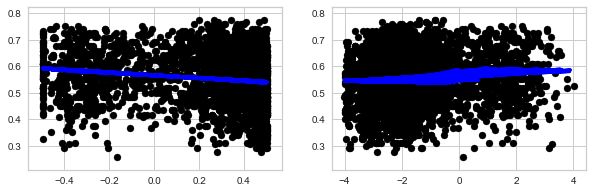

In [17]:
# for a better statistical and graphical interpretation, we now fit a linear regression
# build a data set we can work on:

rt_data = pd.DataFrame(np.vstack([y_f_rt, x_f_pin, x_f_ty, x_f_sub]).T, columns = ['rt', 'pin', 'pos', 'subject'])
rt_train, rt_test = train_test_split(rt_data, test_size = 0.2, random_state = 42)

Y = rt_train.rt.values
X = rt_train[['pin', 'pos']]

# create a linear regression object:
regr = linear_model.LinearRegression()

# train the model
regr.fit(X, Y)

# predict the variables
Y_test = rt_test[['pin', 'pos']]
rt_pred = regr.predict(Y_test)

# get the coefficients:
print('Coefficients: \n', regr.coef_)

# mean squared error
print('MSE: %.2f'%mean_squared_error(rt_test.rt, rt_pred))

# coefficient:
print('Coefficient of determination: %.2f' %r2_score(rt_test.rt, rt_pred))

# plot
lin_fig, lin_axs = plt.subplots(1,2, figsize = (10,3))
lin_axs[0].scatter(X.pin,Y, color = 'black')
lin_axs[0].plot(rt_test.pin.values, rt_pred, color = 'blue', linewidth = 3)
lin_axs[1].scatter(X.pos,Y, color = 'black')
lin_axs[1].plot(rt_test.pos.values, rt_pred, color = 'blue', linewidth = 3)
#lin_axs[2].scatter(X.dir,Y, color = 'black')
#lin_axs[2].plot(rt_test.dir.values, rt_pred, color = 'blue', linewidth = 3)


In [18]:
# save the rmse
RMSE = np.sqrt(((rt_test.rt - rt_pred)**2).values.mean())
results = pd.DataFrame()
results['Method'] = ['Linear Regression']
results['RMSE'] = RMSE
results['CoefPin'] = regr.coef_[0]
results['CoefPos'] = regr.coef_[1]
#results['CoefDir'] = regr.coef_[2]

print(results)

              Method      RMSE   CoefPin   CoefPos
0  Linear Regression  0.096367 -0.060906 -0.001858


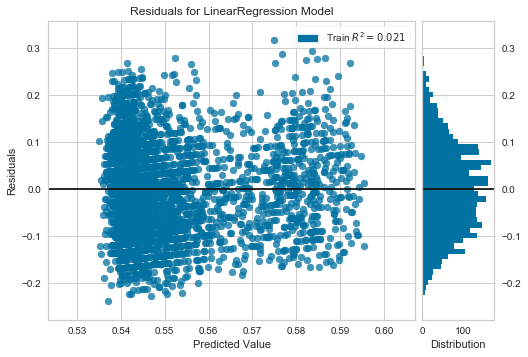

In [19]:
# check the residuals: they should be normally distributed
visualizer = ResidualsPlot(model = regr)
visualizer.fit(X, Y)

visualizer.poof()

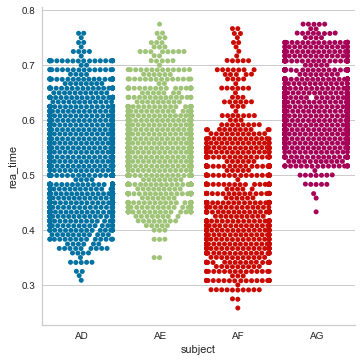

In [20]:
# The residuals don't look bad, but we have a strong belief that the subject should have an influence on the response. 
sns.catplot(x = 'subject', y = 'rea_time', data = data, kind= 'swarm');

#### Linear Mixed Effect Models (subject as random factor) - time averaged

In [21]:
# there is a reaction time difference between subjects - 
# we should compute a mixed effects model to take subjects into account 
subjects = np.unique(rt_data.subject)
#mm_data = pd.concat([rt_data, pd.get_dummies(rt_data.subject)], axis = 1)
mm_data = rt_data
# make sure all relevant factors are numerical
mm_data.rt = pd.to_numeric(mm_data.rt)
mm_data.pin = pd.to_numeric(mm_data.pin)
mm_data.pos = pd.to_numeric(mm_data.pos)
#mm_data.dir = pd.to_numeric(mm_data.dir)

# define and fit the mixed effects model with all predictors and interaction
m_mod = smf.mixedlm("rt ~ pin * pos", mm_data, groups = mm_data['subject'], re_formula = "~  pin * pos")
m_modf = m_mod.fit()
print(m_modf.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   rt       
No. Observations:    4397      Method:               REML     
No. Groups:          4         Scale:                0.0056   
Min. group size:     715       Log-Likelihood:       5115.7338
Max. group size:     1366      Converged:            Yes      
Mean group size:     1099.2                                   
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.571    0.027 20.927 0.000  0.518  0.625
pin                 -0.086    0.024 -3.567 0.000 -0.133 -0.039
pos                 -0.018    0.020 -0.910 0.363 -0.057  0.021
pin:pos              0.044    0.017  2.654 0.008  0.012  0.077
Group Var            0.003    0.019                           
Group x pin Cov      0.000    0.018                           
pin V

The probability of a hit/miss and the position of the sample influence the reaction time. There is also an interaction between p_in and y position.

#### Part 4.2 Fit a logistic regression (Responses) - time averaged

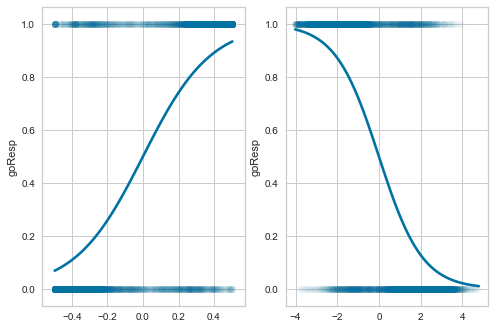

In [22]:
# Next, answers: the answers are a binary variable. Thus, we cannot use the above method. 
# Instead, we compute a binary logistic regression

y_goresp = data.goResp
y_goresp = y_goresp.astype(int)

# x_mean_pin
x_ty = x_n_ty
x_sub = data.subject

# create one testing dataset from this

log_reg_set = pd.DataFrame(np.vstack([y_goresp, x_n_pin, x_ty, x_sub]).T, columns = ['resp', 'pin', 'ypos', 'subject'])

# we start with plotting once more the regression functions we already plotted above

log_fig, log_ax = plt.subplots(1,2)

sns.regplot(x = x_n_pin, y = y_goresp, logistic = True, ci = None, ax = log_ax[0],scatter_kws = {'alpha': 0.02})
sns.regplot(x = x_ty, y = y_goresp, logistic = True, ci = None, ax = log_ax[1], scatter_kws = {'alpha': 0.02});

In [23]:
# set the types of our dataset
log_reg_set.ypos = log_reg_set.ypos.astype(np.float64)
log_reg_set.pin = log_reg_set.pin.astype(np.float64)
log_reg_set.resp = log_reg_set.resp.astype(np.int64)

# split our data in train and test set:
train_data, test_data = train_test_split(log_reg_set, test_size = 0.2, random_state = 42)

formula= ('resp ~ ypos + pin + ypos * pin')
model = logit(formula = formula, data = train_data).fit()

Optimization terminated successfully.
         Current function value: 0.384521
         Iterations 6


In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   resp   No. Observations:                 7031
Model:                          Logit   Df Residuals:                     7027
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 Mar 2021   Pseudo R-squ.:                  0.4453
Time:                        17:10:24   Log-Likelihood:                -2703.6
converged:                       True   LL-Null:                       -4873.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1824      0.056     -3.270      0.001      -0.292      -0.073
ypos          -0.1121      0.052     -2.140      0.032      -0.215      -0.009
pin            4.6916      0.287     16.338      0.000       4.129       5.254
ypos:pin      -0.3098      0.075     -4.141      0.000      -0.456      -0.163
==============================================================================
"""

the above results can be interpreted as follows: 
the y position of the target and the probability both have an influence on the decision. The interaction is also significant

In [25]:
# Evaluating the model on the test set
#compute the prediction
prediciton = model.predict(exog = test_data)

# set a cutoff value to normalize the data to 0 and 1 (like running a softmax)
cutoff = 0.5

# apply cutoff to compute class predicitons
y_prediction = np.where(prediciton > cutoff, 1, 0)

# get ground truth:
y_ground = test_data['resp']

# compute and print a confusion matrix
conf_matrix = pd.crosstab(y_ground, y_prediction, rownames = ['actual'], 
                         colnames = ['predicted'],
                         margins = True)

print(conf_matrix)
print('The accuracy on the test set was {}%'.format(np.round(accuracy_score(y_ground, y_prediction),2)))

# ODDs ratio
# ODDs is the ration of the probability of the event (go-response) occuring over the event not occuring
# it can be found mathematically by taking the exponent of the estimated coefficients

print(np.exp(model.params))

# Compute the classification accuracy
print(classification_report(y_ground, y_prediction))

predicted    0    1   All
actual                   
0          747  129   876
1          141  741   882
All        888  870  1758
The accuracy on the test set was 0.85%
Intercept      0.833268
ypos           0.893927
pin          109.029801
ypos:pin       0.733600
dtype: float64
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       876
           1       0.85      0.84      0.85       882

    accuracy                           0.85      1758
   macro avg       0.85      0.85      0.85      1758
weighted avg       0.85      0.85      0.85      1758



The model we fitted above performs well in predicting the responses of our participants. However, we did not include all factors (e.g. subject are not included as a random variable yet).

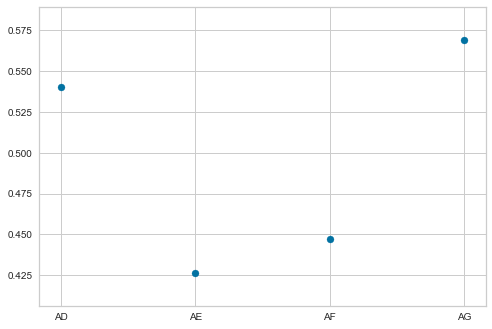

In [26]:
# could there be a difference in the response behaviour of participants? 
resp_table = []
for sub in np.unique(data.subject):
    
    goResp_part = np.mean(data.goResp[data.subject==sub])
    resp_table.append(goResp_part)

plt.scatter(np.unique(data.subject), resp_table, marker = 'o')

#### Logistic mixed effects model (lmer) - time averaged

In [27]:
# Seems like there might be a difference how often participants make a "go" response. 
# That could have an influence on the logistic model. To account for that, we fit a logistic mixed effects model,
# taking the subject as random factor into account

# first fit: with the generalized bayes model in statmodels
r = {"subject" : '0 + subject'}
mod = smgb.BinomialBayesMixedGLM.from_formula('resp ~ pin + ypos + pin*ypos', r, log_reg_set)
fit = mod.fit_map()
fit.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-0.2118,0.2954,,,
pin,M,4.9645,0.2601,,,
ypos,M,-0.1144,0.0471,,,
pin:ypos,M,-0.2947,0.0682,,,
subject,V,-0.5307,0.3591,0.588,0.287,1.206


This one is hard to interpret, I have to look it up.
An easier interpretation is offered by the Lmer model (runs in r, part of the glme4 package but can be executed from python)

In [28]:
# the model would not accept the format of the log_reg_set data frame. 
# the work-around here is to use the original data frame and append the important columns to it.
data['pin_mean'] = log_reg_set.pin.astype(np.float64)
data['pos_mean'] = log_reg_set.ypos.astype(np.float64)

model = Lmer('goResp ~ pos_mean * pin_mean + (1|subject)', data = data, family = 'binomial')
model_f = model.fit()
print(model_f)

Formula: goResp~pos_mean*pin_mean+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 8789	 Groups: {'subject': 4.0}

Log-likelihood: -3230.053 	 AIC: 6470.106

Random effects:

                Name    Var    Std
subject  (Intercept)  0.305  0.552

No random effect correlations specified

Fixed effects:

                   Estimate  2.5_ci  97.5_ci     SE       OR  OR_2.5_ci  \
(Intercept)          -0.217  -0.767    0.334  0.281    0.805      0.464   
pos_mean             -0.100  -0.194   -0.007  0.048    0.905      0.824   
pin_mean              5.053   4.536    5.569  0.264  156.447     93.329   
pos_mean:pin_mean    -0.295  -0.428   -0.161  0.068    0.745      0.651   

                   OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  \
(Intercept)             1.396  0.446        0.317         0.583  -0.772   
pos_mean                0.993  0.475        0.452         0.498  -2.106   
pin_mean              262.252  0.994        0.989         0.996  19

#### Interpretation: 
In this model, as in the other models we've seen before, we find a significant impact of position, probability and the interaction between them on the data. 
here, it seems like position might be weaker in explaining the data than probability (lower z-score). 

Overall, the analysis above show that reaction time and response category can be predicted from the probability of a hit, from the position of the mean sample realtive to the atttacker, and are likely not predicted by coherent motion signals in the direction of the attacker.


#### Part 5.1 "Pruning"
In order to see if we really need all parameters we specified and tested above, I will now build several models to be compared to each other.

In [29]:
# for reaction times, the data set is mm_data
# fit the full model
rt_full = smf.mixedlm("rt ~ pin + pos + pin : pos", mm_data, groups = mm_data['subject'], re_formula = "~  pin + pos + pin : pos")
f_rt_full = rt_full.fit(reml = False)

# main effect only
rt_main = smf.mixedlm("rt ~ pin + pos", mm_data, groups = mm_data['subject'], re_formula = "~  pin + pos")
f_rt_main = rt_main.fit(reml = False)

# every main effect with interaction
rt_pin_i = smf.mixedlm("rt ~ pin + pin:pos", mm_data, groups = mm_data['subject'], re_formula = "~  pin + pin:pos")
f_rt_pin_i = rt_pin_i.fit(reml = False)

rt_pos_i = smf.mixedlm("rt ~ pos + pin:pos", mm_data, groups = mm_data['subject'], re_formula = "~  pos + pin:pos")
f_rt_pos_i = rt_pos_i.fit(reml = False)

# only one main effect
rt_pin = smf.mixedlm("rt ~ pin", mm_data, groups = mm_data['subject'], re_formula = "~  pin")
f_rt_pin = rt_pin.fit(reml = False)

rt_pos = smf.mixedlm("rt ~ pos", mm_data, groups = mm_data['subject'], re_formula = "~  pos")
f_rt_pos = rt_pos.fit(reml = False)


In [30]:
# print out all AIC values:

print('The AIC of the full model is {}'.format(np.round(f_rt_full.aic,2)))
print('The AIC of the main effects model is {}'.format(np.round(f_rt_main.aic,2)))
print('The AIC of the model with probability and interaction is {}'.format(np.round(f_rt_pin_i.aic,2)))
print('The AIC of the model with position and interaction is {}'.format(np.round(f_rt_pos_i.aic,2)))
print('The AIC of the model with probability only is {}'.format(np.round(f_rt_pin.aic,2)))
print('The AIC of the model with position only is {}'.format(np.round(f_rt_pos.aic,2)))

The AIC of the full model is -10238.19
The AIC of the main effects model is -10058.49
The AIC of the model with probability and interaction is -10162.12
The AIC of the model with position and interaction is -10163.9
The AIC of the model with probability only is -10069.16
The AIC of the model with position only is -10012.5


In [31]:
# sort the AICs in a list
AIC_rt = pd.DataFrame(np.zeros((6,2)), columns = ['name','AIC'])

AIC_rt['name'][0]= 'full'
AIC_rt['AIC'][0] = f_rt_full.aic

AIC_rt['name'][1]= 'main'
AIC_rt['AIC'][1] = f_rt_main.aic

AIC_rt['name'][2]= 'pin_i'
AIC_rt['AIC'][2] = f_rt_pin_i.aic

AIC_rt['name'][3]= 'pos_i'
AIC_rt['AIC'][3] = f_rt_pos_i.aic

AIC_rt['name'][4]= 'pin'
AIC_rt['AIC'][4] = f_rt_pin.aic

AIC_rt['name'][5]= 'pos'
AIC_rt['AIC'][5] = f_rt_pos.aic

AIC_rt.sort_values('AIC')

,name,AIC
0,full,-10238.191225
3,pos_i,-10163.902766
2,pin_i,-10162.119748
4,pin,-10069.161508
1,main,-10058.490765
5,pos,-10012.497684


The full model provides the best explanation for the reaction times.

In [32]:
# for responses the data set is log_reg_set

# full model
resp_full = Lmer('goResp ~ pos_mean * pin_mean + (1|subject)', data = data, family = 'binomial')
resp_full.fit()

# main effects only
resp_main = Lmer('goResp ~ pos_mean + pin_mean + (1|subject)', data = data, family = 'binomial')
resp_main.fit()

# probability and interaction
resp_pin_i = Lmer('goResp ~ pin_mean + pos_mean:pin_mean + (1|subject)', data = data, family = 'binomial')
resp_pin_i.fit()

# position and interaction
resp_pos_i = Lmer('goResp ~ pos_mean + pin_mean:pos_mean + (1|subject)', data = data, family = 'binomial')
resp_pos_i.fit()

# position only
resp_pos = Lmer('goResp ~ pos_mean + (1|subject)', data = data, family = 'binomial')
resp_pos.fit()

# probability only
resp_pin = Lmer('goResp ~ pin_mean + (1|subject)', data = data, family = 'binomial')
resp_pin.fit()


Formula: goResp~pos_mean*pin_mean+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 8789	 Groups: {'subject': 4.0}

Log-likelihood: -3230.053 	 AIC: 6470.106

Random effects:

                Name    Var    Std
subject  (Intercept)  0.305  0.552

No random effect correlations specified

Fixed effects:

Formula: goResp~pos_mean+pin_mean+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 8789	 Groups: {'subject': 4.0}

Log-likelihood: -3239.426 	 AIC: 6486.853

Random effects:

                Name    Var    Std
subject  (Intercept)  0.303  0.551

No random effect correlations specified

Fixed effects:

Formula: goResp~pin_mean+pos_mean:pin_mean+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 8789	 Groups: {'subject': 4.0}

Log-likelihood: -3232.267 	 AIC: 6472.533

Random effects:

                Name    Var    Std
subject  (Intercept)  0.304  0.551

No random effect correlations specified

Fixed effec

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.042,-0.585,0.501,0.277,0.959,0.557,1.650,0.490,0.358,0.623,-0.151,0.88,
pin_mean,5.548,5.351,5.745,0.101,256.727,210.723,312.773,0.996,0.995,0.997,55.067,0.00,***


In [33]:
# sort the AICs in a list
AIC_resp = pd.DataFrame(np.zeros((6,2)), columns = ['name','AIC'])

AIC_resp['name'][0]= 'full'
AIC_resp['AIC'][0] = resp_full.AIC

AIC_resp['name'][1]= 'main'
AIC_resp['AIC'][1] = resp_main.AIC

AIC_resp['name'][2]= 'pin_i'
AIC_resp['AIC'][2] = resp_pin_i.AIC

AIC_resp['name'][3]= 'pos_i'
AIC_resp['AIC'][3] = resp_pos_i.AIC

AIC_resp['name'][4]= 'pin'
AIC_resp['AIC'][4] = resp_pin.AIC

AIC_resp['name'][5]= 'pos'
AIC_resp['AIC'][5] = resp_pos.AIC

AIC_resp.sort_values('AIC')

,name,AIC
0,full,6470.105938
2,pin_i,6472.533485
1,main,6486.852965
4,pin,6488.567930
3,pos_i,6898.669667
5,pos,6919.383511


The full model provides the best explanation for the data.

#### Iterim Conclusion
In this part, we have not yet looked at the time resolved information. That means, we can discover general trends, when they were present over the entire trial. However, since this information changes over time, we might miss some trends.

Preliminary, we can conclude that the best model to explain reaction times and responses is the full model, including the position, the probability and the interaction between these factors. But to get a full picture, we need to include the time at which the information was shown.

In [34]:
# For future use - store a shorter version of the data frame

info_cols = ['success', 'subject', 'session', 'block', 'trial', 'in_out', 'up_down', 'difficulty', 'fixT', 'attackerYPos', 'hitGoal', 'goalY', 'attackerY', 'answer', 'rea_time', 'mov_time', 'goResp', 'touchX', 'touchY']
short_df = data[info_cols+p_in_names+target_deg]
df_norm = short_df.copy()

df_norm.posSet_1 = (df_norm.posSet_1-np.mean(df_norm.posSet_1))/np.std(df_norm.posSet_1)
df_norm.posSet_2 = (df_norm.posSet_2-np.mean(df_norm.posSet_2))/np.std(df_norm.posSet_2)
df_norm.posSet_3 = (df_norm.posSet_3-np.mean(df_norm.posSet_3))/np.std(df_norm.posSet_3)
df_norm.posSet_4 = (df_norm.posSet_4-np.mean(df_norm.posSet_4))/np.std(df_norm.posSet_4)
df_norm.posSet_5 = (df_norm.posSet_5-np.mean(df_norm.posSet_5))/np.std(df_norm.posSet_5)
df_norm.posSet_6 = (df_norm.posSet_6-np.mean(df_norm.posSet_6))/np.std(df_norm.posSet_6)

# normalize the probabilitiesnp.
df_norm.pi_pos01 = (df_norm.pi_pos01-np.mean(df_norm.pi_pos01))/np.std(df_norm.pi_pos01)
df_norm.pi_pos02 = (df_norm.pi_pos02-np.mean(df_norm.pi_pos02))/np.std(df_norm.pi_pos02)
df_norm.pi_pos03 = (df_norm.pi_pos03-np.mean(df_norm.pi_pos03))/np.std(df_norm.pi_pos03)
df_norm.pi_pos04 = (df_norm.pi_pos04-np.mean(df_norm.pi_pos04))/np.std(df_norm.pi_pos04)
df_norm.pi_pos05 = (df_norm.pi_pos05-np.mean(df_norm.pi_pos05))/np.std(df_norm.pi_pos05)
df_norm.pi_pos06 = (df_norm.pi_pos06-np.mean(df_norm.pi_pos06))/np.std(df_norm.pi_pos06)


df_norm.posSet_1 = df_norm.posSet_1.astype('float')
df_norm.posSet_2 = df_norm.posSet_2.astype('float')
df_norm.posSet_3 = df_norm.posSet_3.astype('float')
df_norm.posSet_4 = df_norm.posSet_4.astype('float')
df_norm.posSet_5 = df_norm.posSet_5.astype('float')
df_norm.posSet_6 = df_norm.posSet_6.astype('float')

# normalize the probabilitiesnp.
df_norm.pi_pos01 = df_norm.pi_pos01.astype('float')
df_norm.pi_pos02 = df_norm.pi_pos02.astype('float')
df_norm.pi_pos03 = df_norm.pi_pos03.astype('float')
df_norm.pi_pos04 = df_norm.pi_pos04.astype('float')
df_norm.pi_pos05 = df_norm.pi_pos05.astype('float')
df_norm.pi_pos06 = df_norm.pi_pos06.astype('float')



short_df.to_csv('../2_cleaned/short_df_6.csv', header = True, index = False)

#### Part 6.1 Time resolved model wide data format

We have seen that probability and position, as well as their interaction have an impact on the responses and reaction times. The coherence of the dots seems to be irrelevant for the decisions our participants make.

So far, we have looked at the mean values of probability and position over 6 time points. While this allowed us to perform a quick test, it can easily blurr out time resolved effects. Because of this, we want to refine the analysis and include the information at different time points separately. 

Since the above analysis suggested that we want to include position, probability and their interaction into the model, the model itself gets very long.
i.e. for the reaction times, the full model would be specified as

##### rea_time ~ 1 + (intercept)

##### pi_pos01 + pi_pos02 + pi_pos03 + pi_pos04 + pi_pos05 + pi_pos06 + (main effects of probability)

##### posSet_1 + posSet_2 + posSet_3 + posSet_4 + posSet_5 + posSet_6 + (main effects of position)

##### pi_pos01:posSet_1 + pi_pos02:posSet_2 + pi_pos03:posSet_3 + pi_pos04:posSet_4 + pi_pos05:posSet_5 + pi_pos06:posSet_6 + (interaction)

##### (1 + pi_pos01 + pi_pos02 + pi_pos03 + pi_pos04 + pi_pos05 + pi_pos06 + posSet_1 + posSet_2 + posSet_3 + posSet_4 + posSet_5 + posSet_6|subject) (random effects per subject, not including interactions)

This model produces degenerate variance-covariance matrices for the random effects and has highly correlated predictors in the fixed effects (pi_pos01 will be similar to pi_pos02 etc.). That means that I'll have to reduce this model. A procedure for model reduction for both the random effects structure and the fixed effects structure is described in Bates et al 2018 (Parsimoneous Mixed Effects Models). The authors explain their procedure using the lme4 package in R. Unfortunately, not all of the lme4 functions are available through pymer. Therefore, I performed the model reduction directly in R and will continue with the reduced models here. 

The script used for model reduction can be found in the same folder as this script and is called model_pruning.Rmd

As a brief summary of the steps I took to reduce the model:

1. Remove random effects till there are not more random effects than a PCA computed with rePCA needs to explain 100% of the variance.
2. Remove higher-order fixed effects & compare the goodness of the model with AIC.
3. Fixed effects that explain the least variance are removed iteratively, till the AIC suggests that removing more fixed effects does not improve the model.

#### The remaining model for reaction times is the following:

lmer('rea_time ~ 1 + pi_pos01 + pi_pos02 + pi_pos03 + (1 |subject)', data = df_norm, REML = FALSE, family = gaussian)

##### Output from R:

Linear mixed model fit by maximum likelihood  ['lmerMod']

Formula:

rea_time ~ 1 + pi_pos01 + pi_pos02 + pi_pos03 + (1 | subject)

   Data: df_norm

     AIC      BIC   logLik deviance df.resid 
     
-10473.9 -10435.5   5242.9 -10485.9     4391 

Scaled residuals: 

    Min      1Q  Median      3Q     Max 
    
-3.4867 -0.6857 -0.0876  0.6304  4.4396 

Random effects:

 Groups   Name        Variance Std.Dev.
 
 subject  (Intercept) 0.003225 0.05679 
 
 Residual             0.005361 0.07322 
 
Number of obs: 4397, groups:  subject, 4

Fixed effects:

             Estimate Std. Error t value
             
(Intercept)  0.554313   0.028443  19.489

pi_pos01    -0.028741   0.001767 -16.269

pi_pos02    -0.048941   0.007733  -6.329

pi_pos03     0.051166   0.006391   8.006

Correlation of Fixed Effects:

         (Intr) p_ps01 p_ps02
         
pi_pos01 -0.008   

pi_pos02 -0.009 -0.412   

pi_pos03 -0.013  0.031 -0.752


#### And for responses:

lmer('goResp ~ 1 + pi_pos01 + pi_pos02 + pi_pos03 + pi_pos06 + (1 + pi_pos03 | subject)', data = df_norm, family = binomial)

##### Output from R:

Generalized linear mixed model fit by maximum likelihood (Laplace Approximation) [
glmerMod]

 Family: binomial  ( logit )
 
Formula: goResp ~ 1 + pi_pos01 + pi_pos02 + pi_pos03 + pi_pos06 + (1 +  
    pi_pos03 | subject)
    
   Data: df_norm

     AIC      BIC   logLik deviance df.resid 
     
  6103.3   6160.0  -3043.7   6087.3     8781 

Scaled residuals: 

    Min      1Q  Median      3Q     Max 
    
-6.8090 -0.3299  0.1399  0.3178  9.2470 

Random effects:

 Groups  Name        Variance Std.Dev. Corr 
 
 subject (Intercept) 0.3863   0.6215 
 
         pi_pos03    0.7210   0.8491   -0.58
         
Number of obs: 8789, groups:  subject, 4

Fixed effects:

            Estimate Std. Error z value Pr(>|z|) 
            
(Intercept) -0.09588    0.31276  -0.307  0.75918

pi_pos01     0.45355    0.05445   8.330  < 2e-16 ***

pi_pos02     3.01931    0.20780  14.530  < 2e-16 ***

pi_pos03     1.54580    0.47097   3.282  0.00103 ** 

pi_pos06     0.77203    0.13055   5.914 3.34e-09 ***


Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:

         (Intr) p_ps01 p_ps02 p_ps03
         
pi_pos01 -0.005  

pi_pos02  0.002 -0.485  

pi_pos03 -0.523  0.015 -0.217    

pi_pos06 -0.001  0.033 -0.001 -0.292

In [66]:
# Fit the response time model in R
df_go = df_norm[df_norm.goResp == 1]
rt_R = Lmer('rea_time ~ 1 + pi_pos01 + pi_pos02 + pi_pos03 + (1|subject)', data = df_go, family = 'gaussian')
rt_R.fit()

Formula: rea_time~1+pi_pos01+pi_pos02+pi_pos03+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 4397	 Groups: {'subject': 4.0}

Log-likelihood: 5224.387 	 AIC: -10448.773

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.066
Residual               0.005  0.073

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.554,0.490,0.619,0.033,3.008,16.881,0.0,***
pi_pos01,-0.029,-0.032,-0.025,0.002,4390.020,-16.264,0.0,***
pi_pos02,-0.019,-0.024,-0.013,0.003,4390.056,-6.325,0.0,***
pi_pos03,0.021,0.016,0.027,0.003,4390.084,8.003,0.0,***


#### This model reports NaNs that don't exist in the data

In [36]:
# Fit the response time model in python statsmodels

rt_sm = smf.mixedlm("rea_time ~ 1 + pi_pos01 + pi_pos02 + pi_pos03", df_norm, groups = df_norm['subject'], re_formula = "~ 1", missing = 'drop')
rt_smf = rt_sm.fit(reml = False)

print(rt_smf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: rea_time 
No. Observations: 4397    Method:             ML       
No. Groups:       4       Scale:              0.0054   
Min. group size:  715     Log-Likelihood:     5242.9345
Max. group size:  1366    Converged:          Yes      
Mean group size:  1099.2                               
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.554    0.028  19.547 0.000  0.499  0.610
pi_pos01    -0.029    0.002 -16.269 0.000 -0.032 -0.025
pi_pos02    -0.019    0.003  -6.329 0.000 -0.024 -0.013
pi_pos03     0.021    0.003   8.006 0.000  0.016  0.027
Group Var    0.003    0.031                            



In [37]:
# Fit the response model in R

resp_R = Lmer('goResp ~ 1 + pi_pos01 + pi_pos02 + pi_pos03 + pi_pos06 + (1 + pi_pos03 | subject)', data = df_norm, family = 'binomial')
resp_R.fit()

Formula: goResp~1+pi_pos01+pi_pos02+pi_pos03+pi_pos06+(1+pi_pos03|subject)

Family: binomial	 Inference: parametric

Number of observations: 8789	 Groups: {'subject': 4.0}

Log-likelihood: -3043.665 	 AIC: 6103.330

Random effects:

                Name    Var    Std
subject  (Intercept)  0.386  0.621
subject     pi_pos03  0.125  0.354

                 IV1       IV2   Corr
subject  (Intercept)  pi_pos03 -0.581

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.096,-0.709,0.517,0.313,0.909,0.492,1.677,0.476,0.330,0.626,-0.307,0.759,
pi_pos01,0.454,0.347,0.560,0.054,1.574,1.415,1.751,0.611,0.586,0.637,8.331,0.000,***
pi_pos02,1.143,0.989,1.297,0.079,3.136,2.688,3.659,0.758,0.729,0.785,14.532,0.000,***
pi_pos03,0.645,0.260,1.029,0.196,1.906,1.297,2.799,0.656,0.565,0.737,3.285,0.001,**
pi_pos06,0.363,0.243,0.483,0.061,1.437,1.275,1.621,0.590,0.560,0.618,5.915,0.000,***


Mixed effect models for logistic regressions don't exist in statsmodels so far.

The models are the same in the python and r implementation. Since one analysis is not possible within the python framework of choice, the analysis will be based on the results form R.

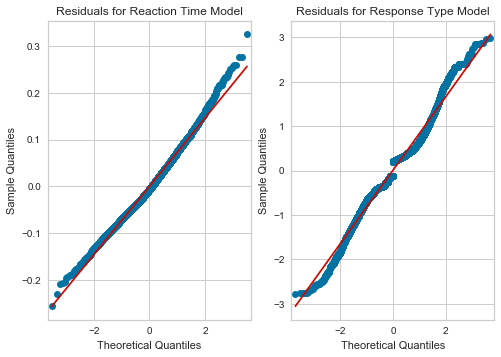

In [38]:
# Checking model asumptions: normaly distributed residuals
residual_fig, residual_axs = plt.subplots(1,2)

sm.qqplot(rt_R.residuals, line = 's', ax=residual_axs[0]);
sm.qqplot(resp_R.residuals, line = 's', ax=residual_axs[1]);

residual_axs[0].set_title('Residuals for Reaction Time Model')
residual_axs[1].set_title('Residuals for Response Type Model');


The residuals are well behaved. The response type model is bimodal, therefore we would expect the little gap in the middle.

In [39]:
df_norm.describe()[['pi_pos01','pi_pos02','pi_pos03']]

,pi_pos01,pi_pos02,pi_pos03
count,8.789000e+03,8.789000e+03,8.789000e+03
mean,-4.409944e-16,-5.030931e-15,-3.247153e-15
std,1.000057e+00,1.000057e+00,1.000057e+00
min,-1.586375e+00,-1.308459e+00,-1.196527e+00
25%,-7.669335e-01,-1.085669e+00,-1.196527e+00
50%,4.500983e-02,4.285844e-03,5.252793e-03
75%,8.493802e-01,1.044859e+00,1.200940e+00
max,1.670283e+00,1.333281e+00,1.200940e+00


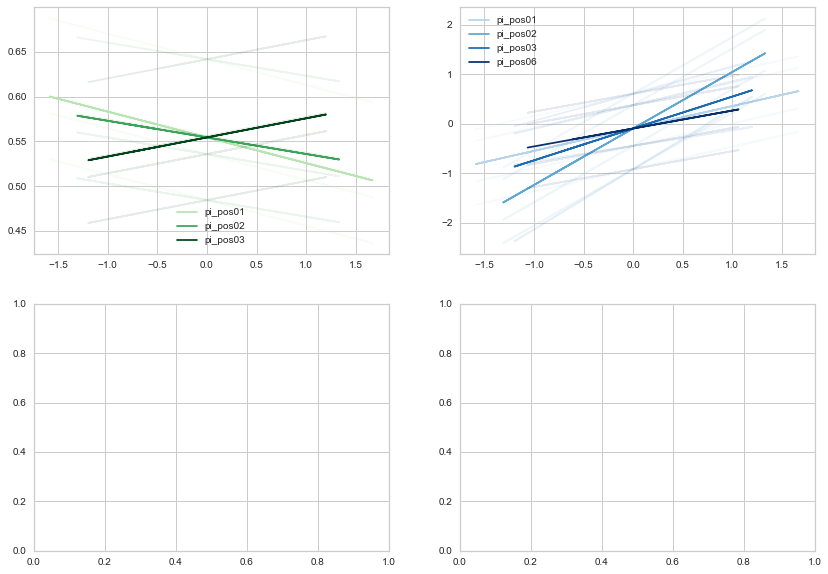

In [40]:
# Visualize the two models 
modelfig, modelaxs = plt.subplots(2,2, figsize = (14,10))

#pred_rt = rt_R.predict(df_norm)
#pred_resp = resp_R.predict(df_norm)

cmap_rt = plt.cm.Greens(np.linspace(0.3,1,3))

for tp,c in zip(['pi_pos01', 'pi_pos02', 'pi_pos03'], cmap_rt):
    
    est = rt_R.coefs.Estimate['(Intercept)'] + df_norm[tp]*rt_R.coefs.Estimate[tp]
    modelaxs[0,0].plot(df_norm[tp],est, color = c, label = tp)
    
    for sid, s in enumerate(np.unique(df_norm.subject)):
        
        est_s = rt_R.fixef['(Intercept)'][sid] + df_norm[df_norm.subject == s][tp]*rt_R.fixef[tp][sid]
        modelaxs[0,0].plot(df_norm[df_norm.subject == s][tp],est_s, color = c, alpha = 0.1)
        
cmap_resp = plt.cm.Blues(np.linspace(0.3,1,4))       
        
for tp,c in zip(['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos06'] , cmap_resp):
    
    est = resp_R.coefs.Estimate['(Intercept)'] + df_norm[tp]*resp_R.coefs.Estimate[tp]
    modelaxs[0,1].plot(df_norm[tp],est, color = c, label = tp)
    
    for sid, s in enumerate(np.unique(df_norm.subject)):
        
        est_s = resp_R.fixef['(Intercept)'][sid] + df_norm[df_norm.subject == s][tp]*resp_R.fixef[tp][sid]
        modelaxs[0,1].plot(df_norm[df_norm.subject == s][tp],est_s, color = c, alpha = 0.1)
    
modelaxs[0,0].legend()
modelaxs[0,1].legend();

### Analysis in long data format:

We can reshape the data frame such that it lists all timepoints in rows - instead of listing them in columns as above.
This is called a long format data frame.

Using the long data frame, we can make explicit assumptions about the correlation between time points. 
However, there is an essential caveat: 

When we compute the probability of a hit, we take into account all samples presented up to the current timepoint.
This already introduced an interaction between time and probability.

So for the long data format, we will try a different approach:

1. We will compute the probability of a "hit" trial with every new sample independently. This results in independence between the probability and time.
2. We will introduce a measure for "repetition" - i.e. a new sample that is located between two old samples will be labeled "repeated", and other samples will be labeled "new". 

In [61]:
# include time as a separate modulator
# reshape the data set such that time has it's own column


def time_stack(df,pin_names,pos_names,time_names):
    
    tps = len(time_names)
    times = df[time_names]
    pin = df[pin_names]
    pos = df[pos_names]
    
    info = df.drop(np.hstack([pin_names,pos_names,time_names]),axis = 1)
    cols = info.columns
    
    long_dat = []
    for col in cols:
        
        unpacked_col = info[col].repeat(tps)
        long_dat.append(unpacked_col)
        
    out_info = np.array(long_dat).T
    out_tp = times.stack()
    out_pin = pin.stack()
    out_pos = pos.stack()
    
    info_df = pd.DataFrame(out_info, columns = cols)
    tp_df = pd.DataFrame(out_tp.values, columns = ['time'])
    pin_df = pd.DataFrame(out_pin.values, columns = ['pin_t'])
    pos_df = pd.DataFrame(out_pos.values, columns = ['pos_t'])
    out_df = pd.concat([info_df, tp_df, pin_df, pos_df], axis = 1)
    
    return out_df

tp_long = time_stack(data, p_in_names, target_deg, time_names)

In [42]:
tp_long

,goalPos,difficulty,in_out,up_down,fixT,attackerYPos,id,success,rea_time,mov_time,...,answer,indTrial,unidir,start_sign,cover,pin_mean,pos_mean,time,pin_t,pos_t
0,2,1.80997,1,-1,0.612458,-3.80997,2,1,0.432425,0.376048,...,0,0,False,1,3,-0.249551,1.13147,2.0,0.486096,0.301258
1,2,1.80997,1,-1,0.612458,-3.80997,2,1,0.432425,0.376048,...,0,0,False,1,3,-0.249551,1.13147,165.0,0.190052,3.225335
2,2,1.80997,1,-1,0.612458,-3.80997,2,1,0.432425,0.376048,...,0,0,False,1,3,-0.249551,1.13147,332.0,0.190052,2.362545
3,2,1.80997,1,-1,0.612458,-3.80997,2,1,0.432425,0.376048,...,0,0,False,1,3,-0.249551,1.13147,498.0,0.190052,1.703039
4,2,1.80997,1,-1,0.612458,-3.80997,2,1,0.432425,0.376048,...,0,0,False,1,3,-0.249551,1.13147,665.0,0.213758,-0.261664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52729,-4,1.92642,1,-1,0.638251,-9.92642,846,1,NaN,NaN,...,1,8788,False,1,6,-0.229783,1.71647,167.0,0.301150,-2.964336
52730,-4,1.92642,1,-1,0.638251,-9.92642,846,1,NaN,NaN,...,1,8788,False,1,6,-0.229783,1.71647,334.0,0.301150,-3.733896
52731,-4,1.92642,1,-1,0.638251,-9.92642,846,1,NaN,NaN,...,1,8788,False,1,6,-0.229783,1.71647,500.0,0.301150,-6.993957
52732,-4,1.92642,1,-1,0.638251,-9.92642,846,1,NaN,NaN,...,1,8788,False,1,6,-0.229783,1.71647,667.0,0.000000,-1.609487


In [62]:
# compute independent probabilities
goal_size = 8
p = [get_p_in(tp_long.pos_t[n],tp_long.pos_t[n],tp_long.attackerYPos[n],goal_size) for n in tp_long.index]

tp_long['p_ind'] = p

In [63]:
# compute if the information was repeated or new

tp_long['novel'] = np.nan

idx = 0

for t in tp_long.index:
    
    if t%6 == 0:

        ma = np.nan 
        mi = np.nan
    
    p = tp_long.pos_t[t]
    tp_long.novel[t] = int(not(p<=ma and p>=mi))
    ma = max(p,ma)
    mi = min(p,mi)  

In [71]:
# Step 1: Fit the long format model, time is continuous

tp_long.time = tp_long.time.astype(float)
tp_long.p_ind = tp_long.p_ind.astype(float)
tp_long.rea_time = tp_long.rea_time.astype(float)
tp_long.subject = tp_long.subject.astype(str)
tp_long.novel = tp_long.novel.astype(str)

resp_long = tp_long[tp_long.goResp == 1]
resp_long.reset_index(drop=True, inplace = True)

longRT_py = smf.mixedlm('rea_time ~ 1 + p_ind * time * novel', data = resp_long, groups = 'subject', re_formula = "~ 1+novel", missing = 'drop')
longRT_pyf = longRT_py.fit(reml = False)
longRT_pyf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM     Dependent Variable:     rea_time  
No. Observations:      26382       Method:                 ML        
No. Groups:            4           Scale:                  0.0059    
Min. group size:       4290        Log-Likelihood:         30235.0646
Max. group size:       8196        Converged:              Yes       
Mean group size:       6595.5                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.574    0.026 22.144 0.000  0.523  0.624
novel[T.1.0]               -0.001    0.010 -0.071 0.943 -0.021  0.019
p_ind                      -0.053    0.012 -4.278 0.000 -0.078 -0.029
p_ind:novel[T.1.0]          0.002    0.013  0.124 0.901 -0.024  0.027
time                       -0.000    0.000 -2.589 0.010 -0.000 -0.000
time:novel[T.1.0]          -0.000    0.000 -2.188 0.029 -0.000 -0.000
p_ind:time                  0.000    0.000  2.943 0.003  0.000  0.000
p_ind:time:novel[T.1.0]     0.000    0.000  2.263 0.024  0.000  0.000
subject Var                 0.002    0.016                           
subject x novel[T.1.0] Cov  0.000    0.004                           
novel[T.1.0] Var            0.000                                    
=====================================================================

"""

In [65]:
longRT_R = Lmer('rea_time ~ 1 + p_ind * time * novel + (1|subject)', data = resp_long, family = 'gaussian')
longRT_R.fit()

AttributeError: 'float' object has no attribute 'encode'

#### 8.1 Y position error relative to each frame
#### Experimental Stuff so far - this analysis is not done yet, and I am still working on it.
We want to find out, if the position of each sample on the y axis had an influence on where the hand landed.

In [ ]:
# compute the y error on every position
# we take the "old" data frame, with one column per time point

# substract the final y position from each sample position
y_dist = data[ysamp_names].sub(data['touchY'], axis = 0)
# get only those with a response
y_dist_go = y_dist[data.goResp == 1]

# plot the errors in each column
fig_err, axs_err = plt.subplots(1,2, figsize = (10,5))

axs_err[0].violinplot(y_dist_go.T)

# define colors for the regressions
regcols = plt.cm.YlOrRd(np.linspace(0,1,7))[2:]

for col, rc in zip(y_dist_go.columns, regcols):
    sns.regplot(x = data.rea_time[data.goResp == 1], y = y_dist_go[col], logistic = False, order = 1, line_kws = {'color': rc}, scatter_kws = {'color': 'grey', 'alpha': 0.2}, ax = axs_err[1])


In [ ]:
# looks like there is no influence of the single sample position. 
# There might be an influence of the midpoint of the goal or the end of the attacker though.
# Let's check that.

# We will add the error based on attacker and end point to the plots above

y_dist_mid = data.goalY[data.goResp == 1] - data.touchY[data.goResp == 1]
y_dist_att = data.attackerY[data.goResp == 1] - data.touchY[data.goResp == 1]

y_dist_full = pd.concat([y_dist_go, y_dist_mid, y_dist_att], axis = 1)
y_dist_full.columns = ['ty_1', 'ty_2', 'ty_3', 'ty_4', 'ty_5', 'ty_6', 'y_mid', 'y_att']
y_dist_full

# plot the errors in each column
fig_err2, axs_err2 = plt.subplots(1,2, figsize = (10,5))

axs_err2[0].violinplot(y_dist_full.T)

# define colors for the regressions
regcols = plt.cm.YlOrRd(np.linspace(0,1,9))[2:]

for col, rc in zip(y_dist_full.columns, regcols):
    sns.regplot(x = data.rea_time[data.goResp == 1], y = y_dist_full[col], logistic = False, order = 1, line_kws = {'color': rc}, scatter_kws = {'color': 'grey', 'alpha': 0.2}, ax = axs_err2[1])


In [ ]:
# plot regressios against hand landing y with all known y positions

y_pos_dat = pd.concat([data[ysamp_names], data.goalY, data.attackerY], axis = 1)
y_pos_dat = y_pos_dat[data.goResp == 1]

regcols = plt.cm.YlOrRd(np.linspace(0,1,10))[2:]
regfig, regaxs = plt.subplots(1,1, figsize = (5,5))
for col, rc in zip(y_pos_dat.columns, regcols):
    sns.regplot(x = y_pos_dat[col], y = data.touchY[data.goResp == 1], logistic = False, order = 1, line_kws = {'color': rc}, scatter_kws = {'color': 'grey', 'alpha': 0.2}, label = col, ax = regaxs)
regaxs.legend();


In [ ]:
y_pos_dat.columns